[View in Colaboratory](https://colab.research.google.com/github/Hades32/MegaDepth/blob/master/MegaDepthCloud.ipynb)

install dependencies

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

get code

In [11]:
%%bash 
cd /content
if [ -d MegaDepth ]; then
  cd MegaDepth
  git pull
else
  git clone https://github.com/Hades32/MegaDepth.git
  cd MegaDepth
fi
git log -1
curl -o mr_depth.jpg -L 'https://onedrive.live.com/download?resid=1FD9B66B81B450C4!403065&authkey=!ACHA_2WmVDPV0I0'
mkdir -p checkpoints/test_local
cd checkpoints/test_local
if [ -e best_generalization_net_G.pth ]; then
  echo model already downloaded
else
  wget http://www.cs.cornell.edu/projects/megadepth/dataset/models/best_generalization_net_G.pth
fi

Already up-to-date.
commit 69558b64d65367b98faad6d2b6766c02a28d4747
Author: Martin Rauscher <hades32@gmail.com>
Date:   Sun Jun 24 22:41:37 2018 +0200

    next try
model already downloaded


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  469k  100  469k    0     0   234k      0  0:00:02  0:00:02 --:--:--  561k


import code and use

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
%cd /content/MegaDepth

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
/content/MegaDepth


In [14]:
import torch
import sys
from torch.autograd import Variable
import numpy as np
from options.train_options import TrainOptions
opt = TrainOptions().parse()  # set CUDA_VISIBLE_DEVICES before import torch
from data.data_loader import CreateDataLoader
from models.models import create_model
from skimage import io
from skimage.transform import resize


img_path = 'mr_depth.jpg'

model = create_model(opt)

input_height = 384
input_width  = 512


def test_simple(model):
    total_loss =0 
    toal_count = 0
    print("============================= TEST ============================")
    model.switch_to_eval()

    img = np.float32(io.imread(img_path))/255.0
    img = resize(img, (input_height, input_width), order = 1)
    input_img =  torch.from_numpy( np.transpose(img, (2,0,1)) ).contiguous().float()
    input_img = input_img.unsqueeze(0)

    #with torch.no_grad():
    input_images = Variable(input_img.cuda() )
    pred_log_depth = model.netG.forward(input_images) 
    pred_log_depth = torch.squeeze(pred_log_depth)

    pred_depth = torch.exp(pred_log_depth)

    # visualize prediction using inverse depth, so that we don't need sky segmentation (if you want to use RGB map for visualization, \
    # you have to run semantic segmentation to mask the sky first since the depth of sky is random from CNN)
    pred_inv_depth = 1/pred_depth
    pred_inv_depth = pred_inv_depth.data.cpu().numpy()
    # you might also use percentile for better visualization
    pred_inv_depth = pred_inv_depth/np.amax(pred_inv_depth)

    io.imsave('mr_depth.png', pred_inv_depth)
    # print(pred_inv_depth.shape)
    # sys.exit()



test_simple(model)
print("We are done")


------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints/
continue_train: False
display_freq: 100
display_id: 1
display_winsize: 256
fineSize: 256
gpu_ids: [0]
identity: 0.0
input_nc: 3
isTrain: True
lambda_A: 10.0
lambda_B: 10.0
loadSize: 286
lr: 0.0002
max_dataset_size: inf
model: pix2pix
nThreads: 2
name: test_local
ndf: 64
ngf: 64
niter: 100
niter_decay: 100
no_flip: False
no_html: False
no_lsgan: False
norm: instance
output_nc: 3
phase: train
pool_size: 50
print_freq: 100
save_epoch_freq: 5
save_latest_freq: 5000
serial_batches: False
use_dropout: False
which_epoch: latest
which_model_netG: unet_256
-------------- End ----------------
===========================================LOADING Hourglass NETWORK====================================================
./checkpoints/test_local/best_generalization_net_G.pth
model [HGModel] was created
============================= TEST ============================


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:133: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


We are done


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


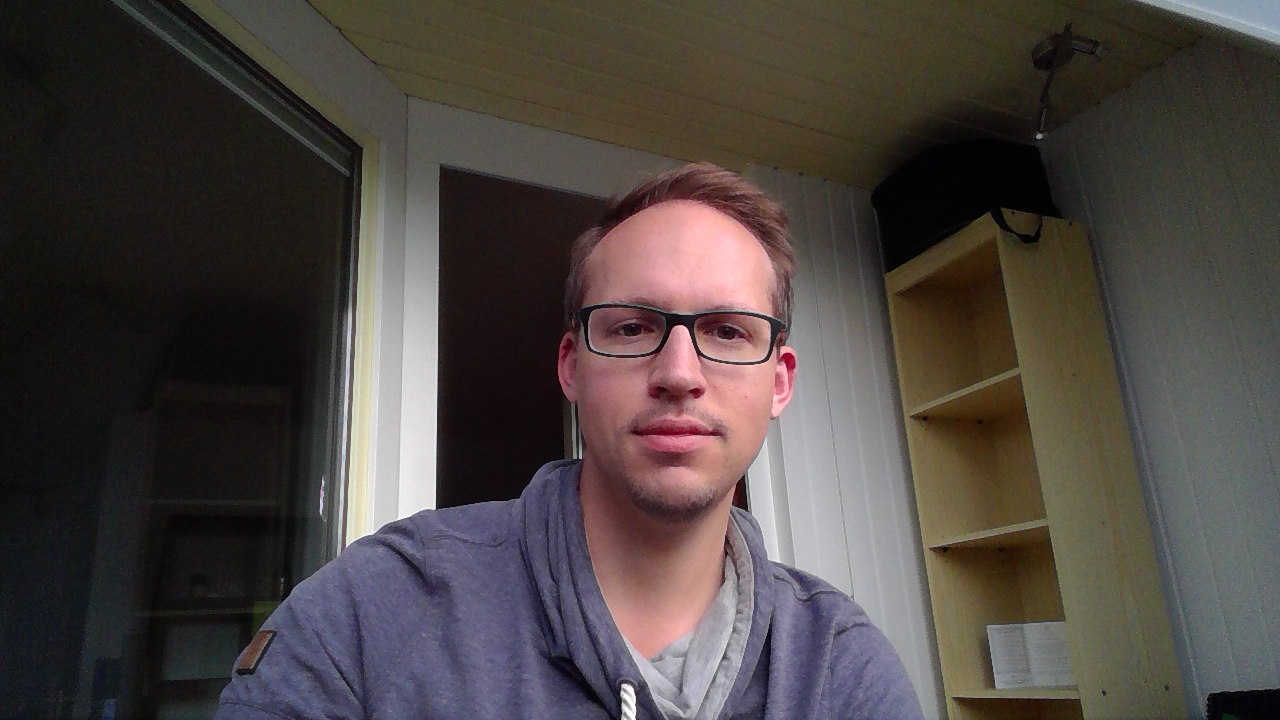

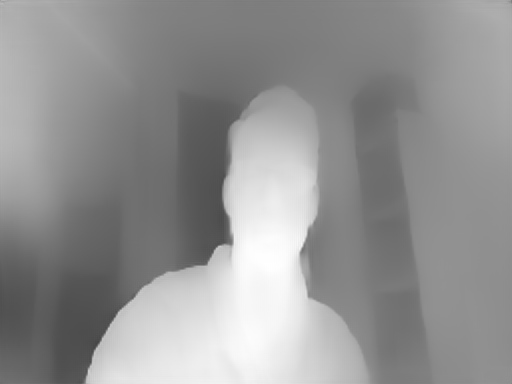

In [15]:
from IPython.display import Image
display(Image(filename='mr_depth.jpg'))
display(Image(filename='mr_depth.png'))